In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

data = pd.read_csv("/kaggle/input/weather-long-term-time-series-forecasting/cleaned_weather.csv")
data.head()

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


In [2]:
data.shape

(52696, 21)

In [3]:
data.columns

Index(['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
       'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR',
       'max. PAR', 'Tlog'],
      dtype='object')

In [4]:
temperature = data["T"].to_numpy()
raw_data = data.drop(columns=["date"]).to_numpy()

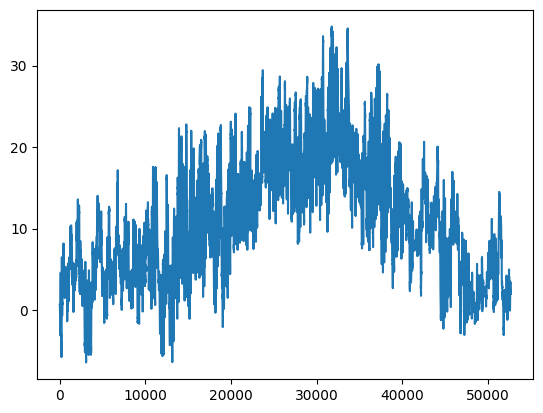

In [5]:
plt.plot(range(len(temperature)), temperature)

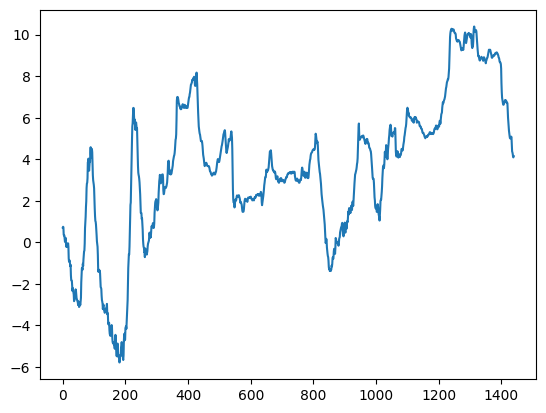

In [6]:
plt.plot(range(1440), temperature[:1440])

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 26348
num_val_samples: 13174
num_test_samples: 13174


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /=std

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2025-09-22 19:42:21.086536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758570141.277593      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758570141.329411      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 19:42:35.026151: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 20)
targets shape: (256,)


In [11]:
# Common-sense baseline

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.82
Test MAE: 2.15


In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GlobalAveragePooling1D()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("weather_longterm_dense.keras",
                                   save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=20,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 126.7696 - mae: 9.3895 - val_loss: 332.4626 - val_mae: 17.3873
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 122.1882 - mae: 9.2099 - val_loss: 317.2344 - val_mae: 16.9560
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 117.7200 - mae: 9.0265 - val_loss: 302.1444 - val_mae: 16.5179
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 113.5495 - mae: 8.8481 - val_loss: 286.6505 - val_mae: 16.0561
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 109.9793 - mae: 8.7014 - val_loss: 270.9386 - val_mae: 15.5741
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 106.0531 - mae: 8.5250 - val_loss: 255.5593 - val_mae: 15.0863
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 101.6400 - mae: 8.3297 - val_loss: 240.4740 - val_mae: 14.5904
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 97.6073 - mae: 8.1448 - val_loss: 225.7789 - val_mae: 14.0895
Epoch 9/2

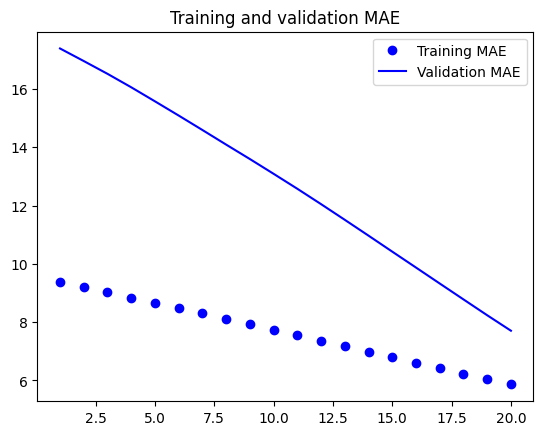

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_conv.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=20,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 118.2486 - mae: 9.0455 - val_loss: 66.7686 - val_mae: 6.6328
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 39.2435 - mae: 4.9355 - val_loss: 43.9270 - val_mae: 5.3544
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 27.8821 - mae: 4.1055 - val_loss: 39.4616 - val_mae: 5.0474
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 25.5562 - mae: 3.9542 - val_loss: 35.6430 - val_mae: 4.7692
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 23.9522 - mae: 3.8417 - val_loss: 33.4943 - val_mae: 4.5980
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 22.8516 - mae: 3.7528 - val_loss: 32.3819 - val_mae: 4.5065
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 21.9192 - mae: 3.6724 - val_loss: 31.9394 - val_mae: 4.4654
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 21.3538 - mae: 3.6247 - val_loss: 31.2876 - val_mae: 4.4184
Epoch 9/20
101/101 ━━━━━━━━━━━━

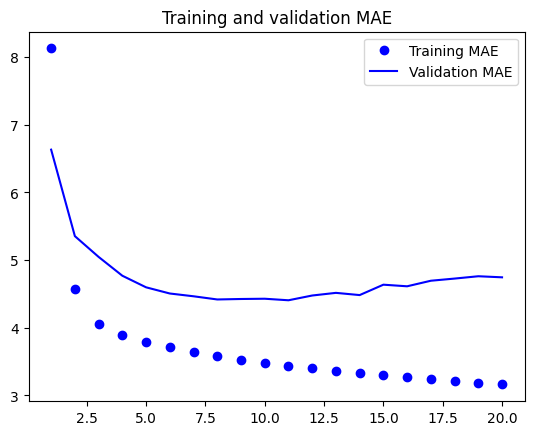

In [16]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_lstm.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=20,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 135.2748 - mae: 9.7383 - val_loss: 356.0818 - val_mae: 17.9433
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 130.9946 - mae: 9.5765 - val_loss: 343.4071 - val_mae: 17.6044
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 126.5046 - mae: 9.4203 - val_loss: 326.3786 - val_mae: 17.1404
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 119.9197 - mae: 9.1776 - val_loss: 308.9673 - val_mae: 16.6345
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 112.6918 - mae: 8.8660 - val_loss: 288.4290 - val_mae: 16.0139
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 102.3013 - mae: 8.3986 - val_loss: 264.6594 - val_mae: 15.2880
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 90.2077 - mae: 7.7611 - val_loss: 245.9719 - val_mae: 14.6849
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 80.4948 - mae: 7.1672 - val_loss: 231.8914 - val_mae: 14.2030
Epoch 9/2

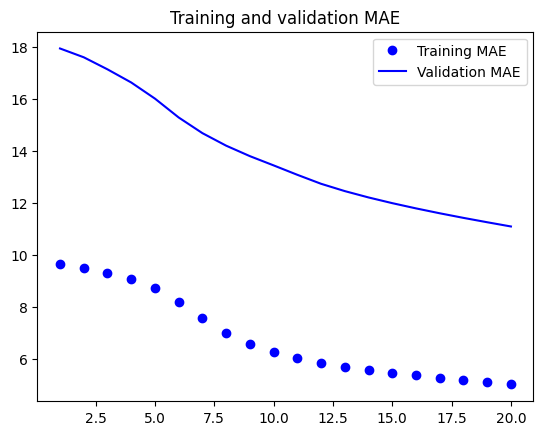

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_Dlstm_dropout.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - loss: 131.9337 - mae: 9.5659 - val_loss: 343.2997 - val_mae: 17.6920
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 120.3470 - mae: 9.1941 - val_loss: 295.5632 - val_mae: 16.3303
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 102.1443 - mae: 8.4408 - val_loss: 229.2884 - val_mae: 14.1429
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 74.3805 - mae: 6.9469 - val_loss: 187.4435 - val_mae: 12.5653
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 55.5081 - mae: 5.7514 - val_loss: 163.3085 - val_mae: 11.5868
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 48.8162 - mae: 5.3658 - val_loss: 147.8702 - val_mae: 10.9151
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 43.5759 - mae: 5.0854 - val_loss: 135.8820 - val_mae: 10.3706
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 40.5655 - mae: 4.9096 - val_loss: 126.1876 - val_mae: 9.9120
Epoc

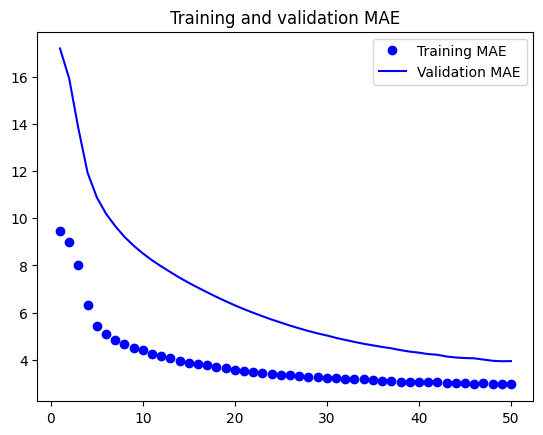

In [21]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
# Stacked LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_lstm_dropout.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - loss: 129.4706 - mae: 9.5440 - val_loss: 321.6619 - val_mae: 17.0493
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 112.0967 - mae: 8.8300 - val_loss: 247.9935 - val_mae: 14.7309
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - loss: 78.0020 - mae: 6.9773 - val_loss: 202.9814 - val_mae: 13.1152
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 61.1131 - mae: 6.0628 - val_loss: 178.0904 - val_mae: 12.1371
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 54.1661 - mae: 5.7035 - val_loss: 161.9174 - val_mae: 11.4615
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 48.6592 - mae: 5.3972 - val_loss: 150.5347 - val_mae: 10.9661
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 44.8166 - mae: 5.1710 - val_loss: 141.6845 - val_mae: 10.5693
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 41.8338 - mae: 4.9902 - val_loss: 134.2375 - val_mae: 10.228

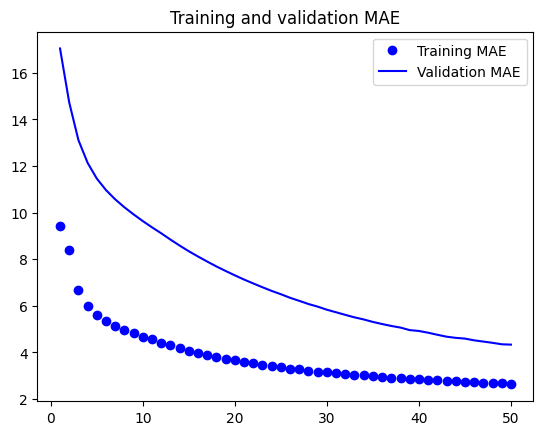

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [16]:
# Stacked GRU

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True, recurrent_dropout=0.2)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_Dgru_dropout.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - loss: 127.4466 - mae: 9.5046 - val_loss: 302.2713 - val_mae: 16.5245
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 113.5394 - mae: 9.1473 - val_loss: 234.5127 - val_mae: 14.4285
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 93.8810 - mae: 8.4172 - val_loss: 178.5741 - val_mae: 12.3507
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 67.4006 - mae: 6.8995 - val_loss: 143.6559 - val_mae: 10.7684
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - loss: 43.9078 - mae: 5.1602 - val_loss: 124.1354 - val_mae: 9.7856
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 37.6417 - mae: 4.7563 - val_loss: 114.7154 - val_mae: 9.3178
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - loss: 34.6647 - mae: 4.5402 - val_loss: 108.0825 - val_mae: 8.9849
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 32.7603 - mae: 4.4136 - val_loss: 102.5402 - val_mae: 8.7020
Ep

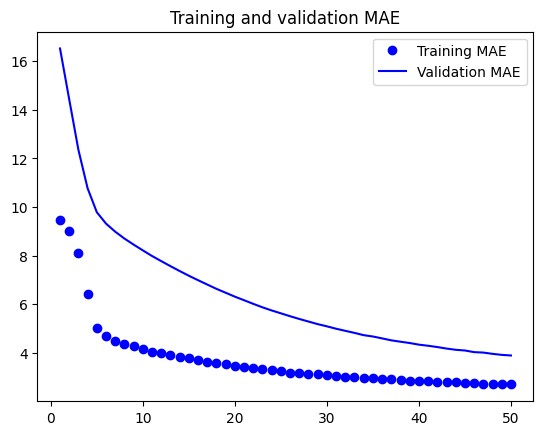

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
# Bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2))(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_BIlstm_dropout.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - loss: 128.5276 - mae: 9.3989 - val_loss: 316.7433 - val_mae: 16.8903
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 111.3955 - mae: 8.7463 - val_loss: 256.1241 - val_mae: 15.0305
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - loss: 85.6333 - mae: 7.5020 - val_loss: 187.8309 - val_mae: 12.5701
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - loss: 52.9158 - mae: 5.6266 - val_loss: 124.1377 - val_mae: 9.7899
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - loss: 36.0302 - mae: 4.6792 - val_loss: 93.0689 - val_mae: 8.2467
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 29.2046 - mae: 4.2440 - val_loss: 76.4733 - val_mae: 7.3362
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 26.0285 - mae: 4.0073 - val_loss: 65.3378 - val_mae: 6.6665
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 23.4075 - mae: 3.7803 - val_loss: 57.6096 - val_mae: 6.1730
Epoch 9

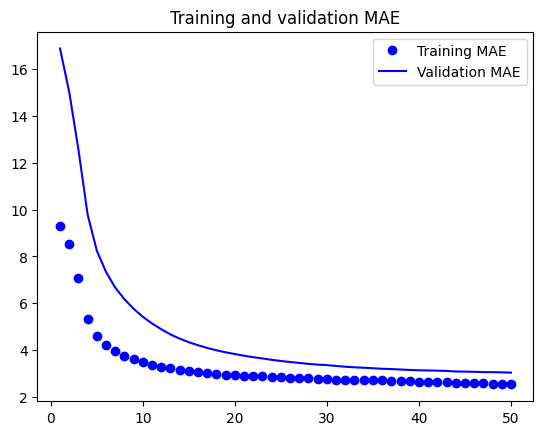

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [11]:
# CNN + RNN

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 5, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(64, 5, activation="relu")(x)

x = layers.LSTM(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_cnn_lstm_dropout.keras",
                                       save_best_only=True)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50


I0000 00:00:1758205631.285498     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 107.3536 - mae: 8.4258 - val_loss: 203.5783 - val_mae: 13.1363
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 60.9965 - mae: 6.0950 - val_loss: 156.6606 - val_mae: 11.2350
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 49.6624 - mae: 5.5166 - val_loss: 143.6469 - val_mae: 10.6539
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 45.3852 - mae: 5.2619 - val_loss: 136.8412 - val_mae: 10.3434
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 43.0098 - mae: 5.1007 - val_loss: 130.7475 - val_mae: 10.0624
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 40.2963 - mae: 4.9012 - val_loss: 124.8969 - val_mae: 9.7890
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 37.7871 - mae: 4.6964 - val_loss: 119.4203 - val_mae: 9.5289
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 35.0520 - mae: 4.4964 - val_loss: 112.5175 - val_mae: 9.1941
Epoch 9/50
10

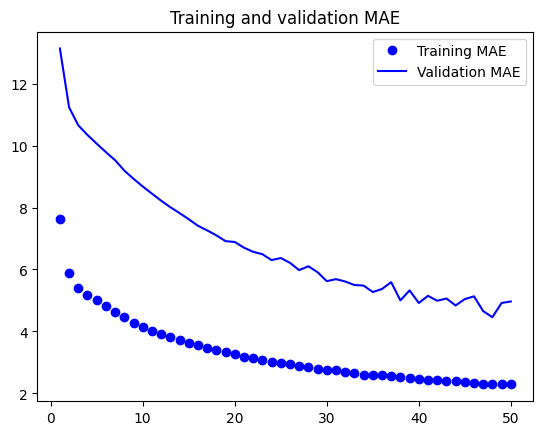

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 5, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(64, 5, activation="relu")(x)

x = layers.LSTM(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("weather_conv_rnn_best.keras",
                    save_best_only=True,
                    monitor="val_mae"),

    keras.callbacks.EarlyStopping(monitor="val_mae",
                  patience=10,
                  verbose=1,
                  restore_best_weights=True),

    keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                      patience=3,
                      factor=0.2,
                      verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - loss: 104.9326 - mae: 8.3097 - val_loss: 209.5292 - val_mae: 13.3577 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 63.1488 - mae: 6.1986 - val_loss: 171.6837 - val_mae: 11.8639 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 53.8374 - mae: 5.7143 - val_loss: 160.1344 - val_mae: 11.3743 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 49.3865 - mae: 5.4680 - val_loss: 150.2731 - val_mae: 10.9457 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 45.8510 - mae: 5.2591 - val_loss: 143.2340 - val_mae: 10.6320 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 42.9200 - mae: 5.0603 - val_loss: 136.7152 - val_mae: 10.3366 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 40.6499 - mae: 4.8

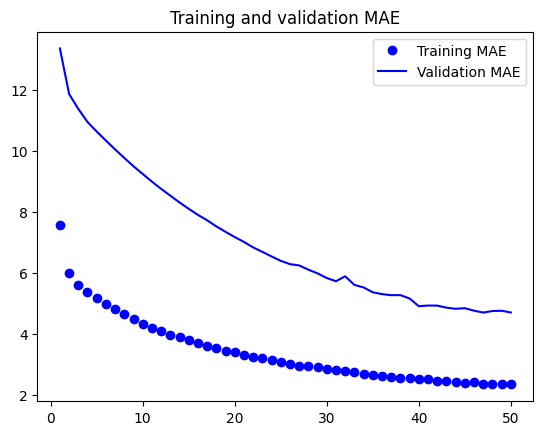

In [16]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 5, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Dropout(0.3)(x) 
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.LSTM(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, kernel_regularizer=l2(0.001))(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("weather_conv_rnn_dropout_rl2.keras",
                    save_best_only=True,
                    monitor="val_mae"),

    keras.callbacks.EarlyStopping(monitor="val_mae",
                  patience=10,
                  verbose=1,
                  restore_best_weights=True),

    keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                      patience=3,
                      factor=0.2,
                      verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 118.9868 - mae: 8.9561 - val_loss: 236.4227 - val_mae: 14.3143 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 70.4817 - mae: 6.5568 - val_loss: 160.9200 - val_mae: 11.4181 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 51.2924 - mae: 5.6206 - val_loss: 141.8079 - val_mae: 10.5690 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 45.2874 - mae: 5.2666 - val_loss: 133.3994 - val_mae: 10.1834 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 41.7939 - mae: 5.0268 - val_loss: 127.4207 - val_mae: 9.9045 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 39.1917 - mae: 4.8488 - val_loss: 121.8738 - val_mae: 9.6416 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 36.6737 - mae: 4.657

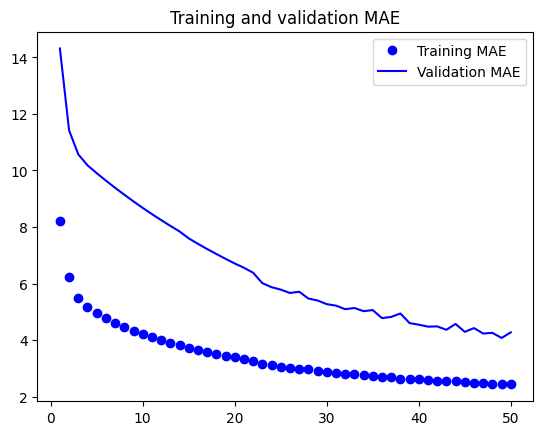

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [11]:
# Bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2))(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_bilstm_best.keras",
                                        save_best_only=True,
                                        monitor="val_mae"),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=5,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-3),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - loss: 100.1939 - mae: 8.1831 - val_loss: 74.4202 - val_mae: 7.2149 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 21.0131 - mae: 3.5634 - val_loss: 31.9619 - val_mae: 4.3420 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - loss: 14.6970 - mae: 2.9792 - val_loss: 24.0436 - val_mae: 3.7468 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 13.3605 - mae: 2.8442 - val_loss: 20.2989 - val_mae: 3.4450 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 12.2872 - mae: 2.7111 - val_loss: 18.1068 - val_mae: 3.2647 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - loss: 11.6250 - mae: 2.6569 - val_loss: 16.5344 - val_mae: 3.1366 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 10.8514 - mae: 2.5702 - val_loss: 15.9468 - val

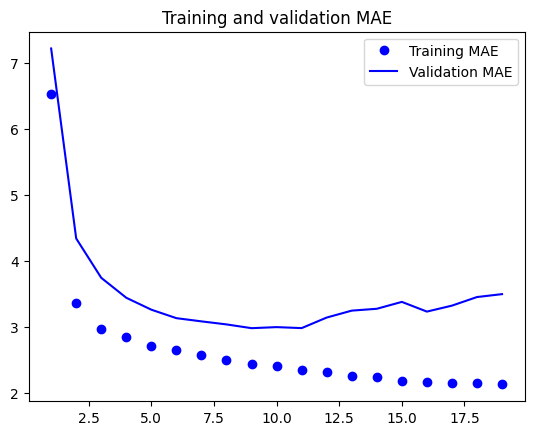

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, kernel_regularizer=l2(0.001))(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_bilstm_bestv2.keras",
                                        save_best_only=True,
                                        monitor="val_mae"),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=5,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-3),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - loss: 80.0274 - mae: 7.0761 - val_loss: 51.1215 - val_mae: 5.6887 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 435ms/step - loss: 16.9687 - mae: 3.1656 - val_loss: 28.4670 - val_mae: 4.0570 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 11.8095 - mae: 2.6481 - val_loss: 21.4541 - val_mae: 3.5242 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - loss: 9.5252 - mae: 2.3783 - val_loss: 19.5310 - val_mae: 3.4360 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 421ms/step - loss: 8.0770 - mae: 2.1947 - val_loss: 19.3365 - val_mae: 3.4613 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 7.1237 - mae: 2.0526 - val_loss: 20.2412 - val_mae: 3.5111 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - loss: 6.3957 - mae: 1.9435 - val_loss: 17.9306 - val_mae:

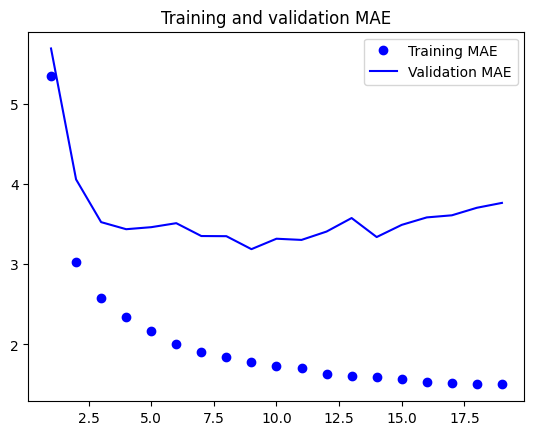

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Changing Parameters

In [10]:
sampling_rate = 12
sequence_length = 72
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2025-09-22 19:00:01.929133: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 72, 20)
targets shape: (256,)


In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_Dlstm_dropout.keras",
                                       save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=5,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 133.1921 - mae: 9.7147 - val_loss: 321.3217 - val_mae: 17.0330 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 120.8521 - mae: 9.2660 - val_loss: 277.3793 - val_mae: 15.7270 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 104.9926 - mae: 8.5984 - val_loss: 233.0452 - val_mae: 14.2535 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 81.7197 - mae: 7.3656 - val_loss: 196.7595 - val_mae: 12.9014 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 61.5938 - mae: 6.1594 - val_loss: 167.0676 - val_mae: 11.7146 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 51.4557 - mae: 5.6144 - val_loss: 146.6317 - val_mae: 10.8466 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 46.3589 - mae: 5.3628 - val

In [15]:
# Bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2))(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_bilstm_best.keras",
                                        save_best_only=True,
                                        monitor="val_mae"),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=3,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-3),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - loss: 94.6370 - mae: 7.9779 - val_loss: 58.0364 - val_mae: 6.2304 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 22.7248 - mae: 3.7488 - val_loss: 31.2739 - val_mae: 4.3788 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 16.6531 - mae: 3.1981 - val_loss: 29.4403 - val_mae: 4.2549 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 13.8792 - mae: 2.9135 - val_loss: 28.7945 - val_mae: 4.2287 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 12.1171 - mae: 2.7258 - val_loss: 29.9052 - val_mae: 4.3254 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 10.9582 - mae: 2.5841 - val_loss: 28.1590 - val_mae: 4.2191 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 9.9187 - mae: 2.4579 - val_loss: 27.8285 - val_m

In [17]:
# Stacked GRU

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True, recurrent_dropout=0.2)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_longterm_Dgru_dropout.keras",
                                       save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=3,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-3),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - loss: 98.4702 - mae: 8.3261 - val_loss: 115.3835 - val_mae: 9.3406 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 34.8954 - mae: 4.6168 - val_loss: 74.3042 - val_mae: 7.2029 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 24.8151 - mae: 3.8631 - val_loss: 53.3131 - val_mae: 5.9299 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 20.0606 - mae: 3.4579 - val_loss: 42.1929 - val_mae: 5.2066 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 17.6169 - mae: 3.2261 - val_loss: 35.9677 - val_mae: 4.7898 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 15.7368 - mae: 3.0528 - val_loss: 32.5181 - val_mae: 4.5473 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 14.5856 - mae: 2.9483 - val_loss: 31.5261 - val

In [13]:
# Bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2))(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("weather_bilstm_best.keras",
                                        save_best_only=True,
                                        monitor="val_mae"),
        keras.callbacks.EarlyStopping(monitor="val_mae",
                                      patience=10, 
                                      verbose=1,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_mae",
                                          patience=5,
                                          factor=0.5,
                                          verbose=1)
]

model.compile(optimizer=keras.optimizers.AdamW(1e-3),
             loss="mse",
             metrics=["mae"])

history = model.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset,
                   callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - loss: 96.6797 - mae: 8.0119 - val_loss: 59.1302 - val_mae: 6.2884 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 22.8762 - mae: 3.7717 - val_loss: 29.6919 - val_mae: 4.2527 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 16.6142 - mae: 3.2028 - val_loss: 25.6532 - val_mae: 3.9417 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 13.8150 - mae: 2.9208 - val_loss: 24.2452 - val_mae: 3.8438 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 12.1725 - mae: 2.7365 - val_loss: 28.3833 - val_mae: 4.1711 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 11.1683 - mae: 2.6128 - val_loss: 34.6677 - val_mae: 4.5978 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 10.3607 - mae: 2.5228 - val_loss: 34.2437 - val_